In [27]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [28]:
#change the tickers here according to what's in the portfolio
tickers = ['ETR','AMD','EPAM','ASML','AUDC','DSGX','MGIC','RDWR',
          'IDXX','IQV','BDSI','ICLR','MEDP','MODV','RGEN','TROW',
          'CG','CSWC','TBBK','CBRE','SBAC','^FVX']

start_date = '2017-01-01'
end_date = '2022-01-01'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [29]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ETR     1259 non-null   float64
 1   AMD     1259 non-null   float64
 2   EPAM    1259 non-null   float64
 3   ASML    1259 non-null   float64
 4   AUDC    1259 non-null   float64
 5   DSGX    1259 non-null   float64
 6   MGIC    1259 non-null   float64
 7   RDWR    1259 non-null   float64
 8   IDXX    1259 non-null   float64
 9   IQV     1259 non-null   float64
 10  BDSI    1259 non-null   float64
 11  ICLR    1259 non-null   float64
 12  MEDP    1259 non-null   float64
 13  MODV    1259 non-null   float64
 14  RGEN    1259 non-null   float64
 15  TROW    1259 non-null   float64
 16  CG      1259 non-null   float64
 17  CSWC    1259 non-null   float64
 18  TBBK    1259 non-null   float64
 19  CBRE    1259 non-null   float64
 20  SBAC    1259 non-null   float64
 21  ^FVX    1259 non-nu

## Function that saves dataframe to CSV

In [30]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [31]:
# for ticker in tickers:
#     panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
# #     close = panel_data['Close']
#     adj_close = panel_data['Close']
#     save_dataframe_to_csv('close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [32]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [33]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Close'] / df['Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [34]:
for ticker in tickers:
    df = get_df_from_csv('close', ticker)
    add_daily_return_to_df('close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [35]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('close', x)
    
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [36]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Close'].item()

## Returns the value of portfolio by date

In [37]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [38]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [39]:
#change to the list of stocks we using
port_list = ['ETR','AMD','EPAM','ASML','AUDC','DSGX','MGIC','RDWR',
          'IDXX','IQV','BDSI','ICLR','MEDP','MODV','RGEN','TROW',
          'CG','CSWC','TBBK','CBRE','SBAC']

#add in the weightage of stocks
port_shares = [0.1,0.011419,0.024563,0.026617,0.015908,0.014737,
               0.005739,0.001016,0.034424,0.001042,0.006973,
               0.006295,0.008102,0.009335,0.033829,0.02456,
               0.031718,0.021091,0.022631,0.03152,0.06848]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', port_shares, port_list)
tot_port_df

,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,MODV,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,7.294,0.130519,1.563681,2.939848,0.104834,0.313161,0.039599,0.014915,4.048262,0.080161,...,0.358184,1.053773,1.862630,0.494801,0.344627,0.182406,0.995086,7.226694,29.820627,NaN
2017-01-04,7.326,0.130519,1.580875,2.925741,0.103561,0.316109,0.039886,0.014996,3.991463,0.080526,...,0.367612,1.092677,1.890383,0.509074,0.353063,0.171996,1.011162,7.236966,29.933225,0.003776
2017-01-05,7.300,0.128350,1.590454,2.960875,0.100061,0.311688,0.040173,0.014925,3.991807,0.080234,...,0.365932,1.120078,1.875647,0.517003,0.352642,0.162491,1.002651,7.141094,29.839042,-0.003146
2017-01-06,7.324,0.129263,1.642528,2.957681,0.101970,0.313161,0.039886,0.014884,4.074425,0.081088,...,0.368266,1.119740,1.857227,0.528105,0.348001,0.162264,0.983424,7.089049,29.933528,0.003167
2017-01-09,7.109,0.131204,1.641791,2.994146,0.100379,0.312424,0.039886,0.014732,4.097144,0.081266,...,0.365559,1.094030,1.788705,0.529691,0.352642,0.160680,0.981218,7.052755,29.655484,-0.009289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,11.083,1.762637,17.120411,21.597832,0.554394,1.205781,0.122872,0.041473,22.542213,0.293907,...,1.410519,9.061435,4.895299,1.780966,0.529173,0.574601,3.397541,26.252492,128.031425,0.020597
2021-12-28,11.189,1.748820,16.756879,21.420564,0.550576,1.208434,0.120921,0.041077,22.419664,0.292396,...,1.400063,8.584785,4.897510,1.759397,0.527908,0.566907,3.395334,26.346311,126.943482,-0.008497
2021-12-29,11.249,1.692981,16.649785,21.346301,0.553758,1.214918,0.121150,0.042134,22.571473,0.294094,...,1.402304,8.724499,4.851582,1.724508,0.525166,0.577317,3.422442,26.361377,127.071448,0.001008


## Get old data for portfolio

In [40]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', 
                                    port_shares, port_list)
tot_port_df

,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,MODV,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,7.294,0.130519,1.563681,2.939848,0.104834,0.313161,0.039599,0.014915,4.048262,0.080161,...,0.358184,1.053773,1.862630,0.494801,0.344627,0.182406,0.995086,7.226694,29.820627,NaN
2017-01-04,7.326,0.130519,1.580875,2.925741,0.103561,0.316109,0.039886,0.014996,3.991463,0.080526,...,0.367612,1.092677,1.890383,0.509074,0.353063,0.171996,1.011162,7.236966,29.933225,0.003776
2017-01-05,7.300,0.128350,1.590454,2.960875,0.100061,0.311688,0.040173,0.014925,3.991807,0.080234,...,0.365932,1.120078,1.875647,0.517003,0.352642,0.162491,1.002651,7.141094,29.839042,-0.003146
2017-01-06,7.324,0.129263,1.642528,2.957681,0.101970,0.313161,0.039886,0.014884,4.074425,0.081088,...,0.368266,1.119740,1.857227,0.528105,0.348001,0.162264,0.983424,7.089049,29.933528,0.003167
2017-01-09,7.109,0.131204,1.641791,2.994146,0.100379,0.312424,0.039886,0.014732,4.097144,0.081266,...,0.365559,1.094030,1.788705,0.529691,0.352642,0.160680,0.981218,7.052755,29.655484,-0.009289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,11.083,1.762637,17.120411,21.597832,0.554394,1.205781,0.122872,0.041473,22.542213,0.293907,...,1.410519,9.061435,4.895299,1.780966,0.529173,0.574601,3.397541,26.252492,128.031425,0.020597
2021-12-28,11.189,1.748820,16.756879,21.420564,0.550576,1.208434,0.120921,0.041077,22.419664,0.292396,...,1.400063,8.584785,4.897510,1.759397,0.527908,0.566907,3.395334,26.346311,126.943482,-0.008497
2021-12-29,11.249,1.692981,16.649785,21.346301,0.553758,1.214918,0.121150,0.042134,22.571473,0.294094,...,1.402304,8.724499,4.851582,1.724508,0.525166,0.577317,3.422442,26.361377,127.071448,0.001008


## Forecasting

In [41]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [42]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [43]:
tot_port_df

,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,MODV,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,7.294,0.130519,1.563681,2.939848,0.104834,0.313161,0.039599,0.014915,4.048262,0.080161,...,0.358184,1.053773,1.862630,0.494801,0.344627,0.182406,0.995086,7.226694,29.820627,NaN
2017-01-04,7.326,0.130519,1.580875,2.925741,0.103561,0.316109,0.039886,0.014996,3.991463,0.080526,...,0.367612,1.092677,1.890383,0.509074,0.353063,0.171996,1.011162,7.236966,29.933225,0.003776
2017-01-05,7.300,0.128350,1.590454,2.960875,0.100061,0.311688,0.040173,0.014925,3.991807,0.080234,...,0.365932,1.120078,1.875647,0.517003,0.352642,0.162491,1.002651,7.141094,29.839042,-0.003146
2017-01-06,7.324,0.129263,1.642528,2.957681,0.101970,0.313161,0.039886,0.014884,4.074425,0.081088,...,0.368266,1.119740,1.857227,0.528105,0.348001,0.162264,0.983424,7.089049,29.933528,0.003167
2017-01-07,7.324,0.129263,1.642528,2.957681,0.101970,0.313161,0.039886,0.014884,4.074425,0.081088,...,0.368266,1.119740,1.857227,0.528105,0.348001,0.162264,0.983424,7.089049,29.933528,0.003167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,11.083,1.762637,17.120411,21.597832,0.554394,1.205781,0.122872,0.041473,22.542213,0.293907,...,1.410519,9.061435,4.895299,1.780966,0.529173,0.574601,3.397541,26.252492,128.031425,0.020597
2021-12-28,11.189,1.748820,16.756879,21.420564,0.550576,1.208434,0.120921,0.041077,22.419664,0.292396,...,1.400063,8.584785,4.897510,1.759397,0.527908,0.566907,3.395334,26.346311,126.943482,-0.008497
2021-12-29,11.249,1.692981,16.649785,21.346301,0.553758,1.214918,0.121150,0.042134,22.571473,0.294094,...,1.402304,8.724499,4.851582,1.724508,0.525166,0.577317,3.422442,26.361377,127.071448,0.001008


In [44]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['ETR','AMD','EPAM','ASML','AUDC','DSGX','MGIC','RDWR',
          'IDXX','IQV','BDSI','ICLR','MEDP','MODV','RGEN','TROW',
          'CG','CSWC','TBBK','CBRE','SBAC', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [45]:
tot_port_df

,Total
Date,
2017-01-03,29.820627
2017-01-04,29.933225
2017-01-05,29.839042
2017-01-06,29.933528
2017-01-07,29.933528
...,...
2021-12-27,128.031425
2021-12-28,126.943482
2021-12-29,127.071448


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Lags : [1 2]
Observations : 1824


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


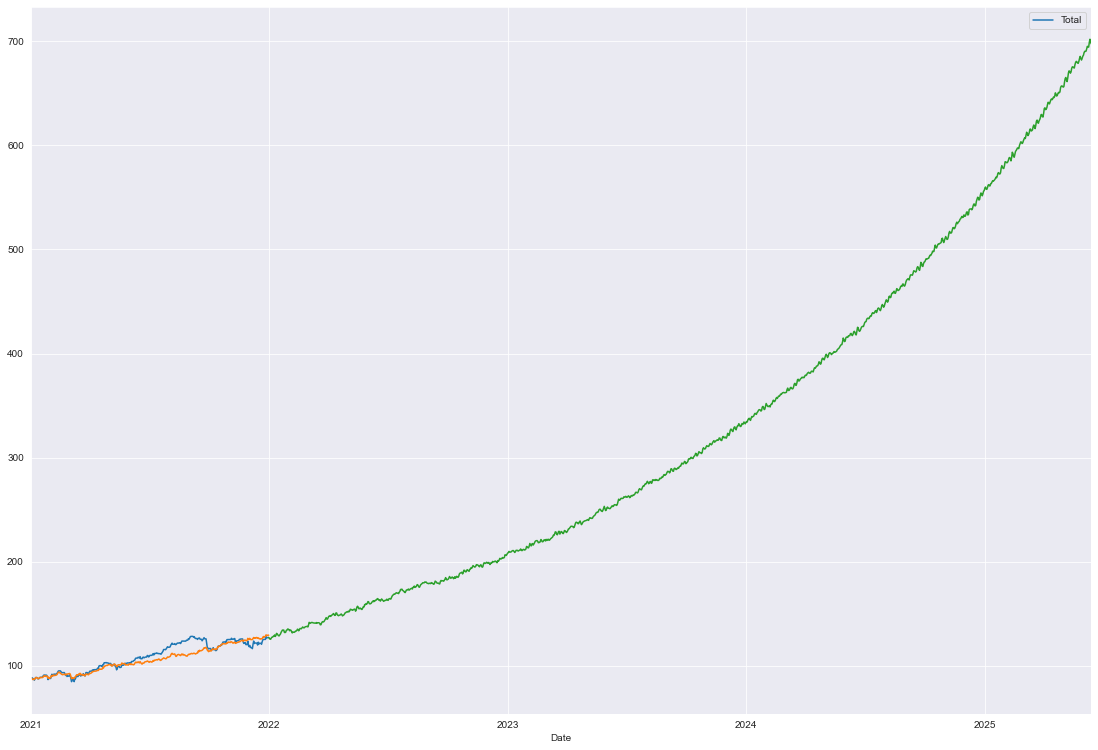

In [46]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+1260, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [47]:
forecast

2021-12-31    127.312076
2022-01-01    126.400710
2022-01-02    125.691622
2022-01-03    125.617641
2022-01-04    126.813945
                 ...    
2025-06-09    694.340966
2025-06-10    698.860461
2025-06-11    701.810234
2025-06-12    699.024227
2025-06-13    697.330980
Freq: D, Length: 1261, dtype: float64

In [48]:
forecast_df = pd.DataFrame(forecast)

In [49]:
forecast_df

,0
2021-12-31,127.312076
2022-01-01,126.400710
2022-01-02,125.691622
2022-01-03,125.617641
2022-01-04,126.813945
...,...
2025-06-09,694.340966
2025-06-10,698.860461
2025-06-11,701.810234
2025-06-12,699.024227


In [50]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [51]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.007159
2022-01-02,-0.012728
2022-01-03,-0.013309
2022-01-04,-0.003913
...,...
2025-06-09,4.453850
2025-06-10,4.489349
2025-06-11,4.512519
2025-06-12,4.490636


In [52]:
#calculate annualized volatility
annualized_vol = np.sqrt(np.log(forecast / forecast.shift(1)).var()) * np.sqrt(252)
annualized_vol*100

6.581105616924944